/tmp/ipykernel_35/896152705.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_35/896152705.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipykernel_35/896152705.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


Epoch [1/50]
  Train -> Acc: 88.78% | Loss: 0.0455
  Val   -> Acc: 92.34% | Loss: 0.0261
  ✅ Best model saved (state_dict).
Epoch [2/50]
  Train -> Acc: 93.85% | Loss: 0.0218
  Val   -> Acc: 93.93% | Loss: 0.0206
  ✅ Best model saved (state_dict).
Epoch [3/50]
  Train -> Acc: 95.08% | Loss: 0.0172
  Val   -> Acc: 95.47% | Loss: 0.0152
  ✅ Best model saved (state_dict).
Epoch [4/50]
  Train -> Acc: 95.88% | Loss: 0.0142
  Val   -> Acc: 95.67% | Loss: 0.0138
  ✅ Best model saved (state_dict).
Epoch [5/50]
  Train -> Acc: 96.11% | Loss: 0.0136
  Val   -> Acc: 95.64% | Loss: 0.0155
  No improvement.
Epoch [6/50]
  Train -> Acc: 96.36% | Loss: 0.0119
  Val   -> Acc: 96.61% | Loss: 0.0110
  ✅ Best model saved (state_dict).
Epoch [7/50]
  Train -> Acc: 96.81% | Loss: 0.0107
  Val   -> Acc: 96.80% | Loss: 0.0099
  ✅ Best model saved (state_dict).
Epoch [8/50]
  Train -> Acc: 97.06% | Loss: 0.0098
  Val   -> Acc: 97.10% | Loss: 0.0095
  ✅ Best model saved (state_dict).
Epoch [9/50]
  Train -> A

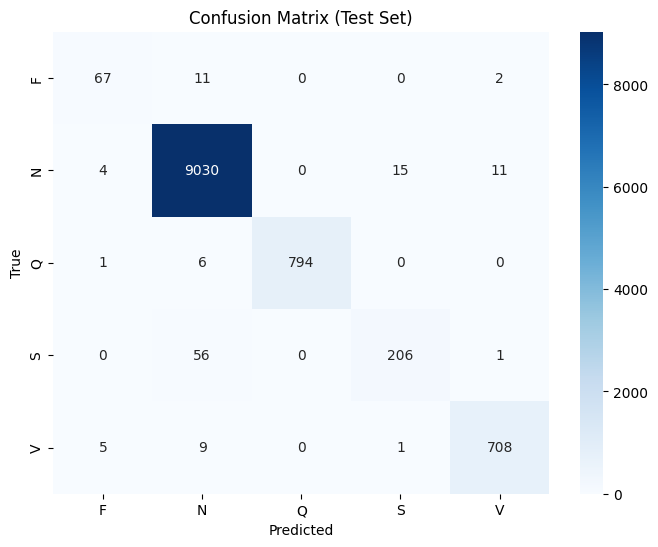


=== Model Complexity ===
📊 Params: 153.74 k
📊 FLOPs: 46.6 MMac


(ECGModel(
   (multi_scale_conv): MultiScaleConv1D(
     (conv3): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
     (conv5): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
     (conv7): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
     (relu): ReLU()
   )
   (conv): Conv1d(96, 64, kernel_size=(3,), stride=(1,), padding=(1,))
   (relu): ReLU()
   (beat_bilstm): LSTM(64, 64, batch_first=True, bidirectional=True)
   (beat_attention): AttentionLayer(
     (attention_weights): Sequential(
       (0): Linear(in_features=128, out_features=1, bias=True)
       (1): Tanh()
       (2): Softmax(dim=1)
     )
   )
   (rhythm_bilstm): LSTM(64, 64, batch_first=True, bidirectional=True)
   (rhythm_attention): AttentionLayer(
     (attention_weights): Sequential(
       (0): Linear(in_features=128, out_features=1, bias=True)
       (1): Tanh()
       (2): Softmax(dim=1)
     )
   )
   (fc): Linear(in_features=256, out_features=5, bias=True)
 ),
 {'train_acc': [8

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan  6 11:55:56 2025

@author: 29551
"""
!pip install ptflops
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, recall_score, precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from ptflops import get_model_complexity_info
import time
# 读取数据
data = pd.read_csv('/kaggle/input/mitbih/ECG_data.csv')

# 提取信号和标签
signals = data['Signal'].apply(lambda x: np.fromstring(x[1:-1], sep=',')).values
labels = data['Label'].values

# 转换信号为 NumPy 数组
signals = np.array([np.array(signal) for signal in signals])

# 转换信号为 PyTorch 张量
signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)  # 增加通道维度 (N, 1, 300)

# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


# 划分训练和测试集
X_train, X_temp, y_train, y_temp = train_test_split(
    signals, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded)

# 第二步：将临时集中的 2/3 设为验证集（20%），1/3 设为测试集（10%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Focal Loss 定义
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)  # 计算 p_t
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


# 注意力层定义
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Tanh(),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        weights = self.attention_weights(x)
        context_vector = torch.sum(weights * x, dim=1)
        return context_vector

# 模型定义
class MultiScaleConv1D(nn.Module):
    """
    多尺度卷积模块。
    包括三种卷积核尺寸的并行卷积，分别为3、5、7。
    """
    def __init__(self, in_channels, out_channels):
        super(MultiScaleConv1D, self).__init__()
        self.conv3 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 三种卷积操作
        out3 = self.relu(self.conv3(x))
        out5 = self.relu(self.conv5(x))
        out7 = self.relu(self.conv7(x))
        
        # 特征融合（按通道维度拼接）
        out = torch.cat([out3, out5, out7], dim=1)
        return out


class ECGModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(ECGModel, self).__init__()
        # 多尺度卷积模块：输入1通道，输出96通道（32*3）
        self.multi_scale_conv = MultiScaleConv1D(1, 32)

        # 后续卷积和激活
        self.conv = nn.Conv1d(96, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # 心拍级别 (Beat Level)
        self.beat_bilstm = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        self.beat_attention = AttentionLayer(128)

        # 节律级别 (Rhythm Level)
        self.rhythm_bilstm = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        self.rhythm_attention = AttentionLayer(128)

        # 全连接层
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # 多尺度卷积
        x = self.multi_scale_conv(x)

        # 后续卷积和激活
        x = self.conv(x)
        x = self.relu(x)

        # 调整为 (batch_size, seq_length, features)
        x = x.permute(0, 2, 1)

        # 心拍级别
        beat_out, _ = self.beat_bilstm(x)
        beat_attention = self.beat_attention(beat_out)

        # 节律级别
        rhythm_out, _ = self.rhythm_bilstm(x)
        rhythm_attention = self.rhythm_attention(rhythm_out)

        # 合并特征
        combined = torch.cat([beat_attention, rhythm_attention], dim=1)
        outputs = self.fc(combined)
        return outputs

# 模型、损失函数和优化器
input_length = 300
num_classes = 5
model = ECGModel(input_length, num_classes)
criterion = FocalLoss(gamma=2.0, alpha=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def compute_test_metrics(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    start_time = time.time()  # ✅ 开始计时
    
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    end_time = time.time()  # ✅ 结束计时
    elapsed_time = end_time - start_time
    accuracy = 100 * correct / total
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    sensitivity = recall_score(all_targets, all_predictions, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')

    conf_matrix = confusion_matrix(all_targets, all_predictions)
    tn = conf_matrix.sum() - conf_matrix.sum(axis=0) - conf_matrix.sum(axis=1) + np.diagonal(conf_matrix)
    fp = conf_matrix.sum(axis=0) - np.diagonal(conf_matrix)
    specificity_per_class = tn / (tn + fp + 1e-6)
    samples_per_class = conf_matrix.sum(axis=1)
    total_samples = np.sum(samples_per_class)
    specificity = np.sum((samples_per_class / total_samples) * specificity_per_class)

    return accuracy, f1, sensitivity, precision, specificity, conf_matrix,elapsed_time

def plot_acc_loss(history):
    epochs = range(1, len(history['train_acc']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color='tab:blue')
    ax1.plot(epochs, history['train_acc'], label='Train Accuracy', color='tab:blue', linestyle='-')
    ax1.plot(epochs, history['val_acc'], label='Val Accuracy', color='tab:blue', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(80,100)
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(epochs, history['train_loss'], label='Train Loss', color='tab:red', linestyle='-')
    ax2.plot(epochs, history['val_loss'], label='Val Loss', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0,0.05)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title('Accuracy and Loss over Epochs')
    fig.tight_layout()
    plt.savefig("DLA-CLSTM Accuracy_Loss Dual Axis.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs):
    history = {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': []
    }
    best_val_loss = float('inf')
    best_model_path = 'DLA-CLSTM_best_model.pth'
    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train -> Acc: {train_acc:.2f}% | Loss: {train_loss:.4f}")
        print(f"  Val   -> Acc: {val_acc:.2f}% | Loss: {val_loss:.4f}")
        # === Save Best Model (based on validation loss) ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print("  ✅ Best model saved (state_dict).")
        else:
            print("  No improvement.")

    # === 重新加载最优模型进行测试 ===
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # === 测试集评估 ===
    start_time = time.time()
    test_acc, test_f1, test_sen, test_ppv, test_spe, conf_matrix, test_time = compute_test_metrics(model, test_loader)
    test_time = time.time() - start_time

    print("\n=== Final Test Set Performance ===")
    print(f"Test Acc: {test_acc:.2f}% | F1: {test_f1:.4f} | Sensitivity: {test_sen:.4f} | "
          f"PPV: {test_ppv:.4f} | Specificity: {test_spe:.4f}")
    print(f"🕒 Inference Time on Test Set: {test_time:.2f} seconds")
    pd.DataFrame({
        'Accuracy (%)': [test_acc],
        'F1 Score': [test_f1],
        'Sensitivity': [test_sen],
        'Precision (PPV)': [test_ppv],
        'Specificity': [test_spe]
    }).to_csv("DLA-CLSTM Test Metrics.csv", index=False)

    # 混淆矩阵图
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.savefig("DLA-CLSTM Confusion Matrix.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    # === 计算模型参数量和 FLOPs ===
    print("\n=== Model Complexity ===")
    macs, params = get_model_complexity_info(
        model, input_res=(1, X_train_tensor.shape[2]), as_strings=True,
        print_per_layer_stat=False, verbose=False
    )
    print(f"📊 Params: {params}")
    print(f"📊 FLOPs: {macs}")

    # === 保存模型结构复杂度信息到文件 ===
    with open("DLA-CLSTM_Model_Complexity.txt", "w") as f:
        f.write(f"Params: {params}\nFLOPs: {macs}\nTest Time: {test_time:.2f} sec")

    return model, history

train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=50)
        


        